In [200]:
import pandas
import os
wd = os.getcwd()

## Read in Review Files and create a pandas dataframe (code borrowed from Julian McAuley website) ##
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

food_review = getDF(os.path.join(wd,"..","..","data/raw/reviews_Grocery_and_Gourmet_Food.json.gz"))

In [201]:
##Miki's code for merging data
##Keeping a subset of the data, to those with our initial "Recall" categorization
import os
wd = os.getcwd()
asins_dir = os.path.join(wd,"..","..","asins")
with open(os.path.join(asins_dir, "asin_intersection.txt")) as asin_file:
    asin_intersection= asin_file.read().splitlines()
    asin_file.close()
    
df_recall = pd.DataFrame({"asin": asin_intersection})
rev_recall = pd.merge(food_review, df_recall, how = "outer", on = ["asin"], indicator = True)
rev_recall["recalled"] = rev_recall["_merge"] == "both"
rev_recall = rev_recall.drop("_merge",1)

food_review_recall = rev_recall[rev_recall['recalled'] == True]

In [202]:
##Call in data that includes UPC/ASINs from original press release data
recall_data = pandas.read_csv(os.path.join(wd,"..","..","data/processed/recalls_upcs_asins_joined.csv"), index_col=0,
                              encoding='ISO-8859-1')

In [203]:
##Pull in recall dates based on ASIN matching
row_iterator = food_review_recall.iterrows()
recall_dates = []

for index, row in row_iterator:
    asin = row['asin']
    row_count = -1
    recall_date = ""
    for asin_list in recall_data['asins']:
        row_count += 1
        if isinstance(asin_list, str):
            if asin in asin_list:
                recall_date = recall_data.DATE[row_count]
    recall_dates.append(recall_date)

In [204]:
##Create Recall Date DataFrame and append it to food_review_dataset
recall_date_df = pandas.DataFrame(recall_dates, columns=['Recall_date'])

In [205]:
##Combine Recall Date DataFrame with overall recall dataframe
food_review_recall = food_review_recall.reset_index(drop=True)
combined_df = pandas.concat([food_review_recall, recall_date_df], axis=1)

In [206]:
##Format Dates to match
combined_df['unixReviewTime'] = pandas.to_datetime(combined_df['unixReviewTime'], unit='s').dt.date
combined_df['Recall_date'] = pandas.to_datetime(combined_df['Recall_date'], unit='s').dt.date

In [207]:
##Keep only files with a recall date
combined_df = combined_df[combined_df['Recall_date'].notnull() == True]

In [230]:
##function to graph review by date vs. recall date

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
%matplotlib inline

def plotRatingbyASIN(asin):
    plot_set = combined_df[combined_df['asin'] == asin]
    plot_set = plot_set.sort_values(by = 'unixReviewTime')
    
    if len(plot_set) > 1:
    
        ax = plt.subplot()
        ax.plot(date2num(plot_set['unixReviewTime']), plot_set['overall'], label='Rating')
        recall_for_graph = date2num(plot_set.Recall_date.iloc[0])

        xmin, xmax = ax.get_xlim()
        xmax2 = max(xmax, recall_for_graph+10)
        xmin2 = min(xmin, recall_for_graph-10)
        ax.set_xlim([xmin2, xmax2])
        ax.set_ylim([0, 5.25])
        ymin, ymax = ax.get_ylim()

        ax.vlines(x=recall_for_graph, ymin=ymin, ymax=ymax, linewidth=5, color='r', label='Recall')
        ax.set_xlabel("Review Date")
        ax.set_ylabel("Rating")
        ax.set_title(asin)
        plt.xticks(rotation='vertical')
        ax.xaxis_date()
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
    
    return plt.show()

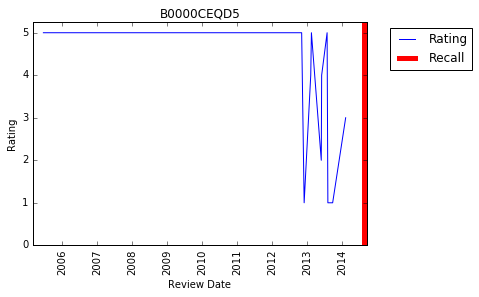

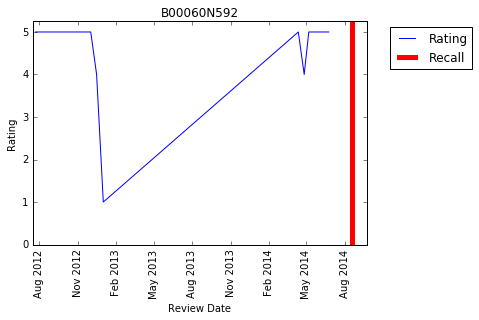

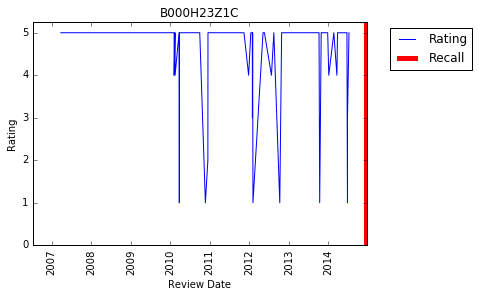

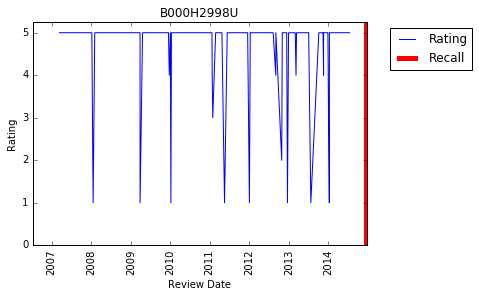

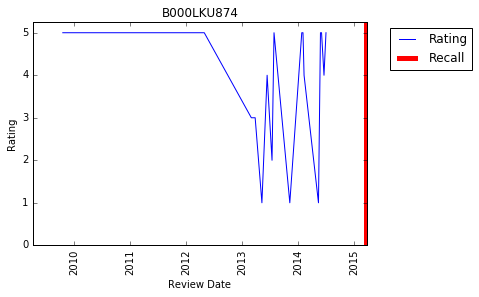

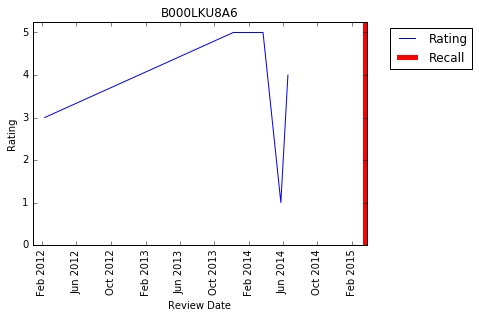

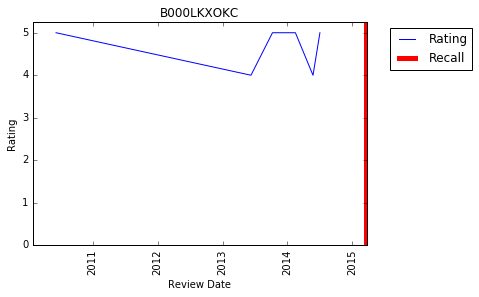

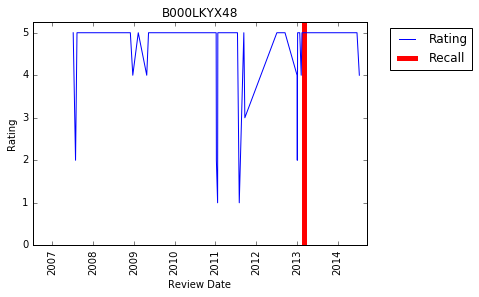

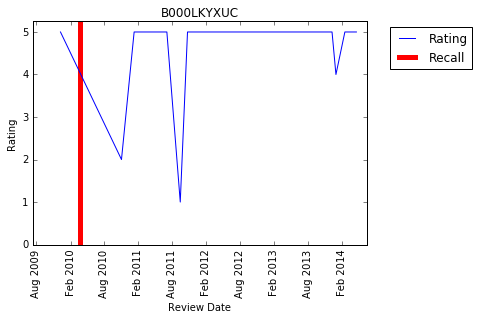

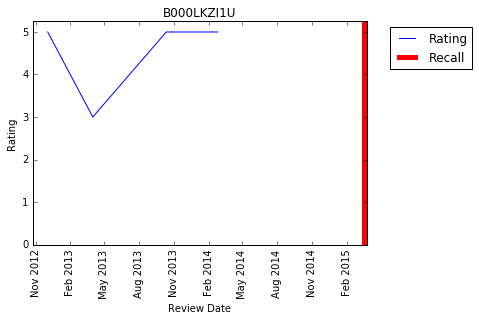

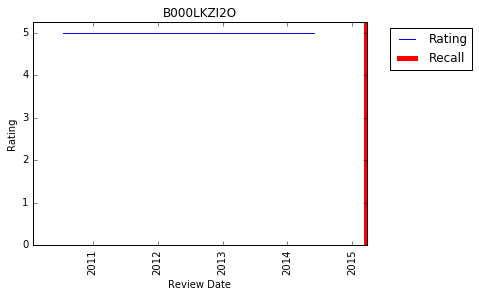

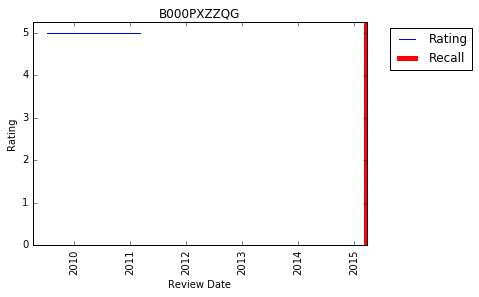

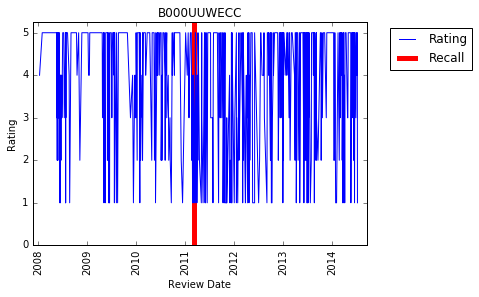

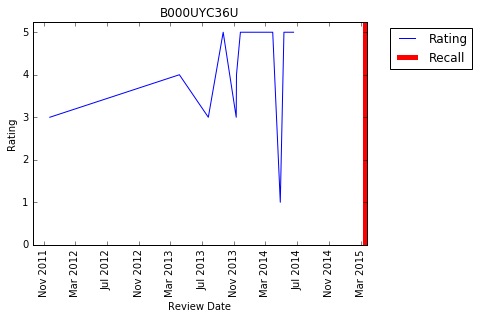

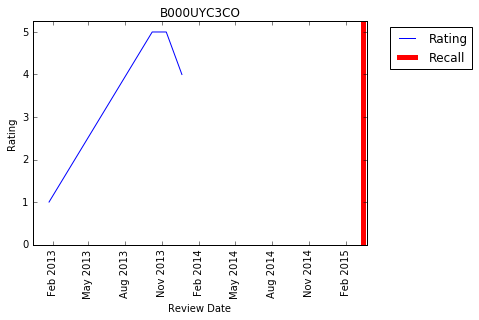

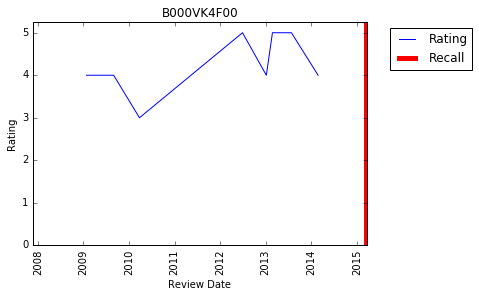

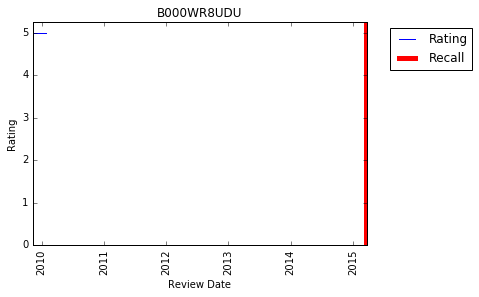

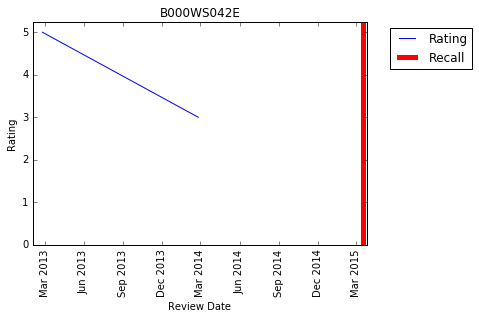

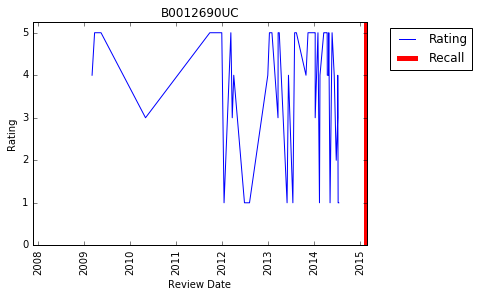

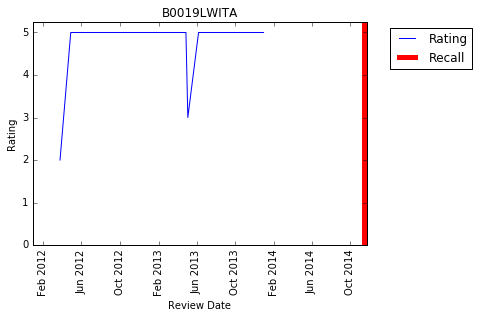

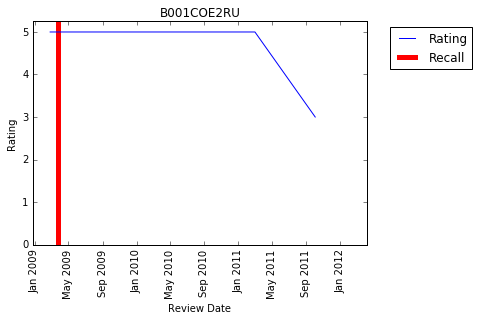

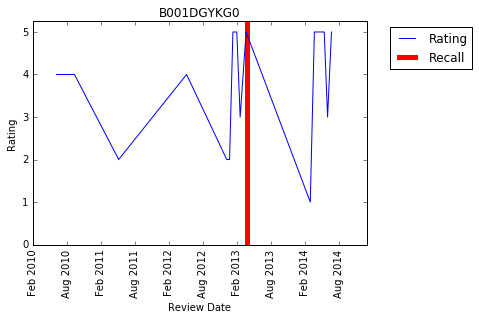

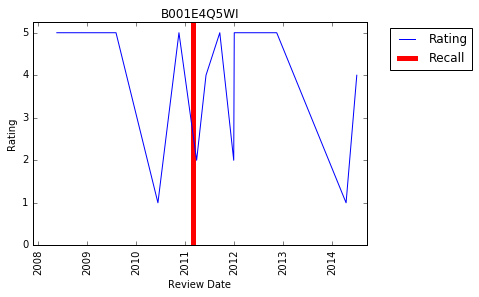

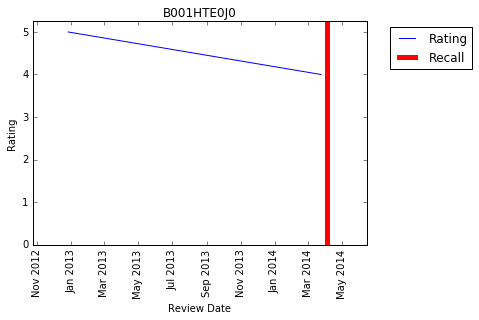

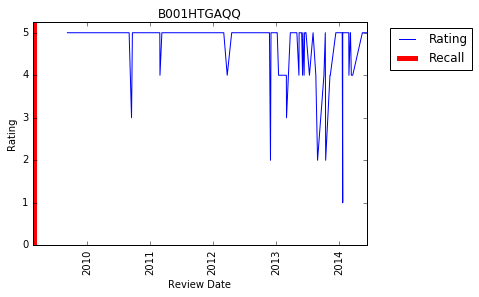

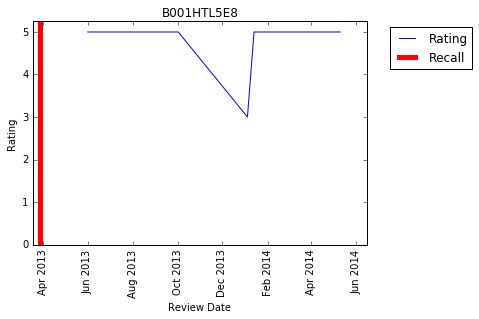

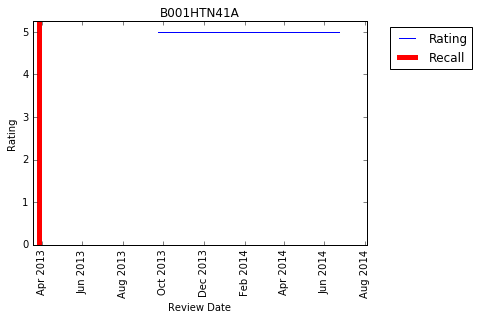

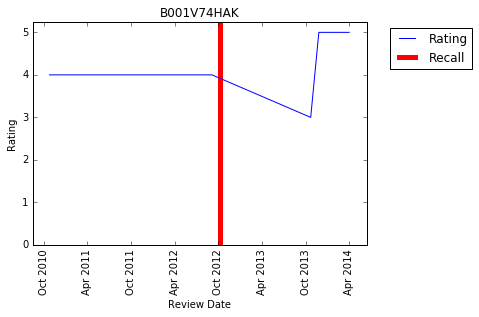

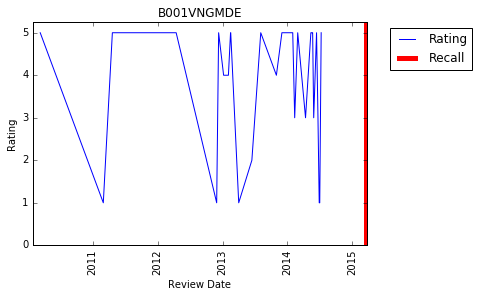

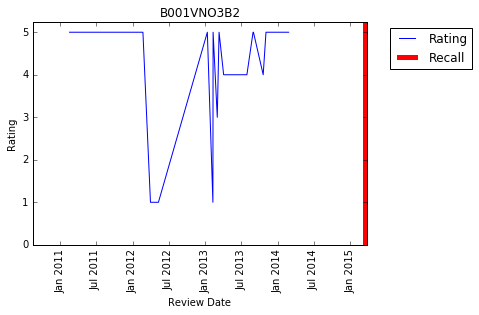

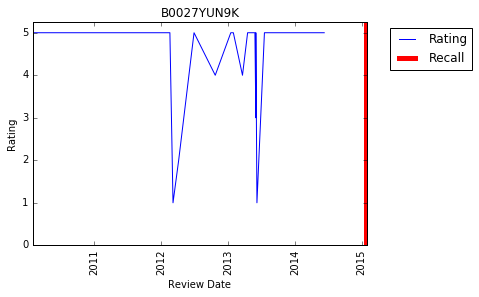

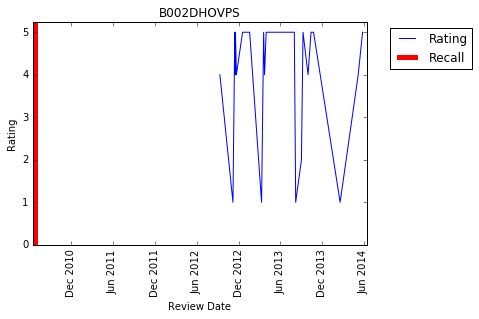

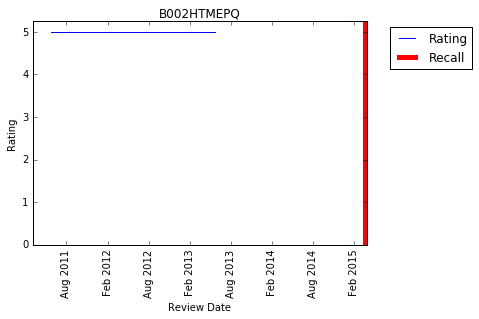

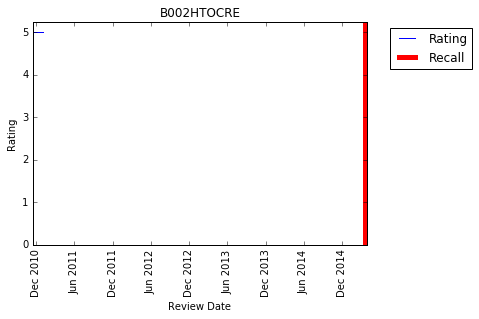

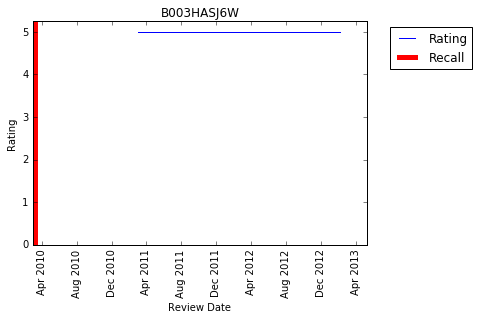

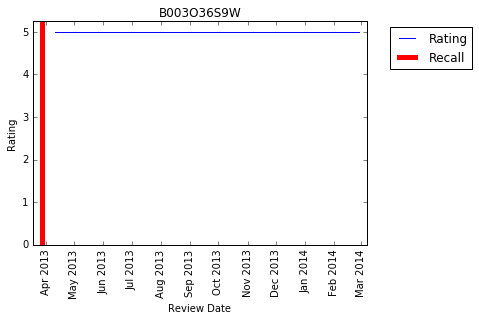

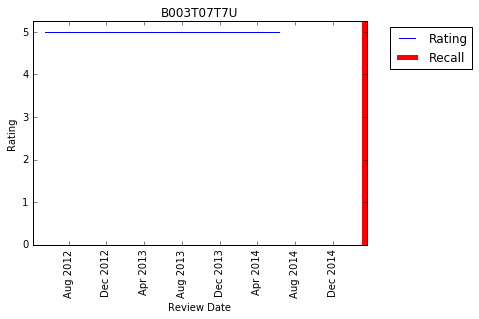

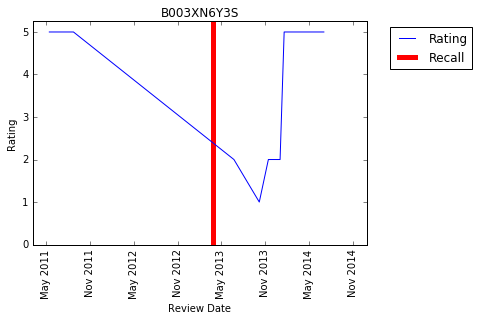

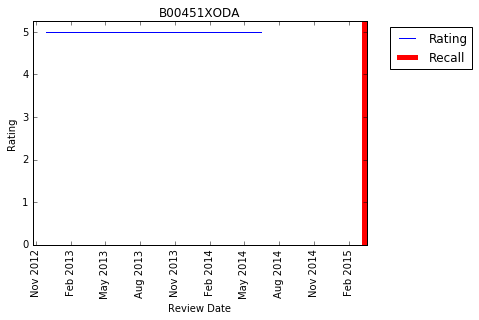

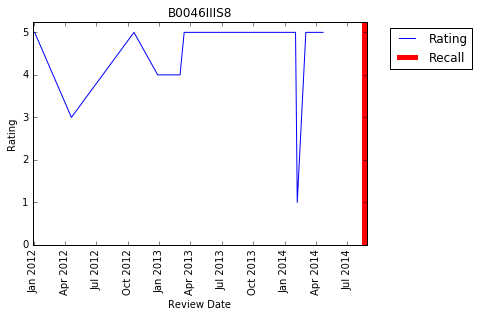

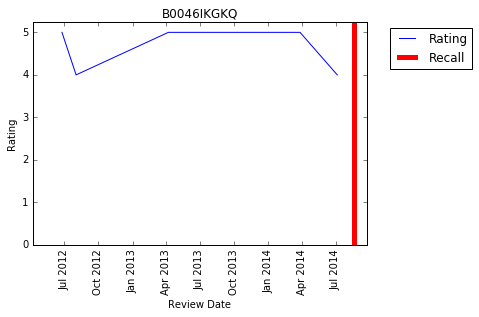

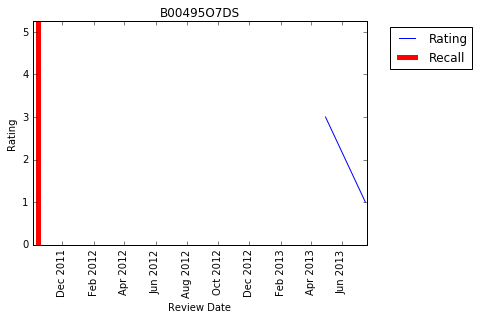

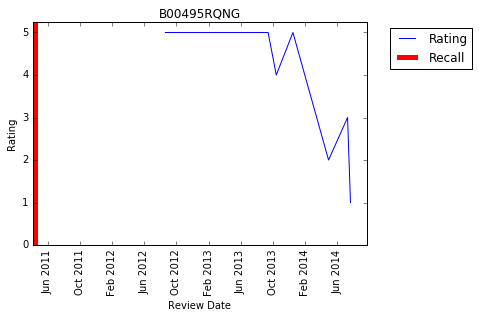

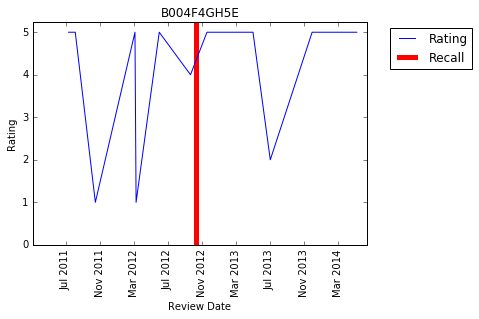

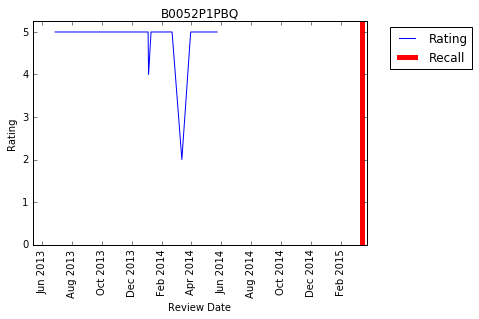

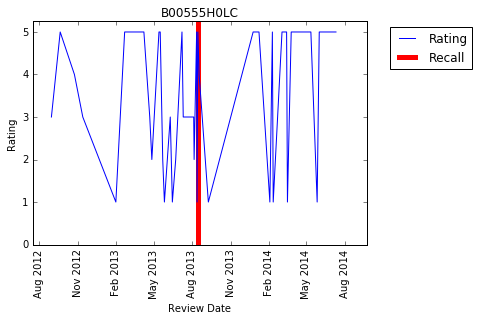

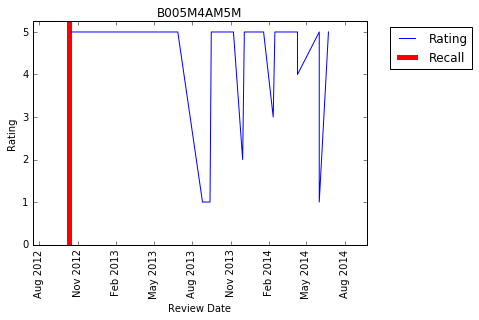

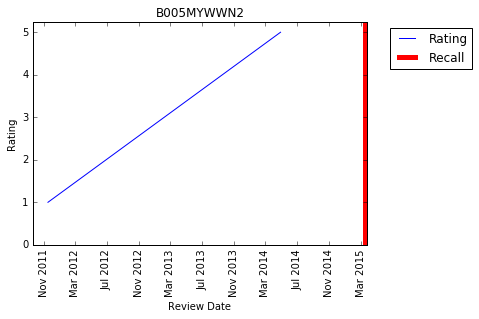

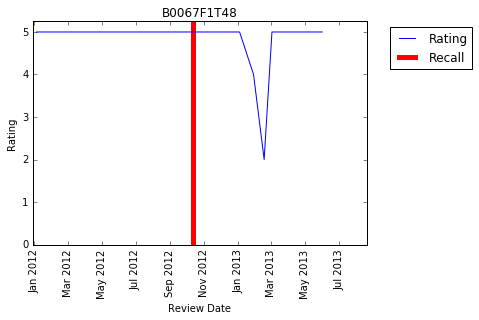

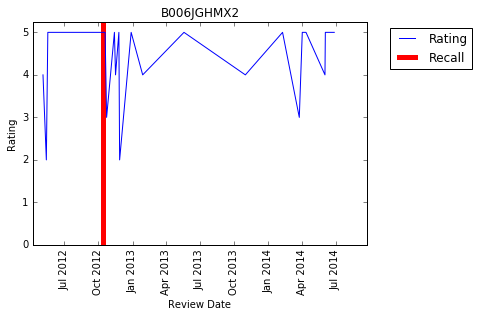

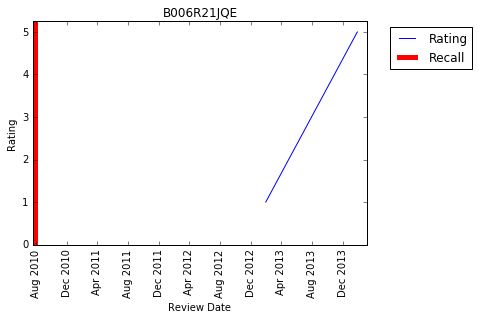

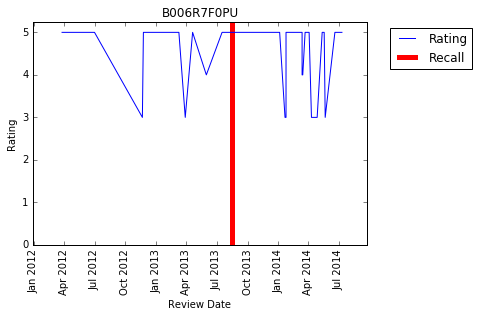

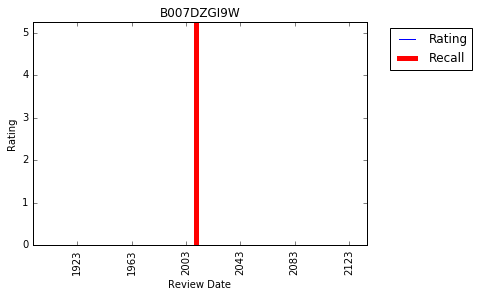

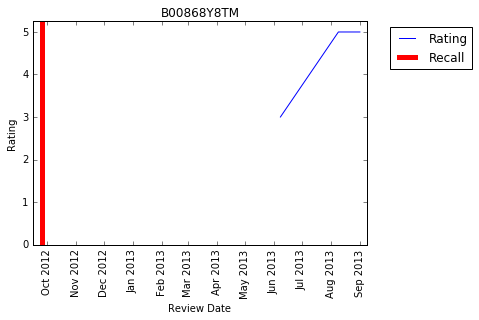

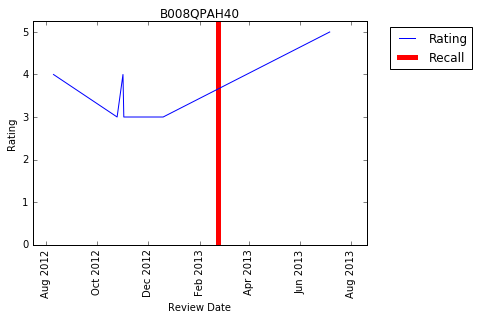

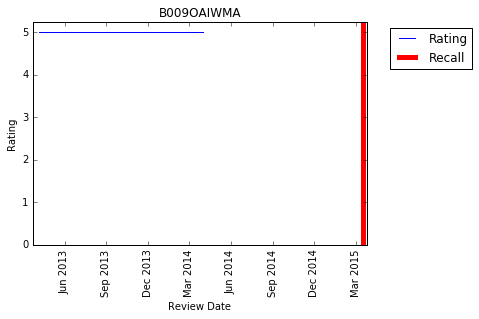

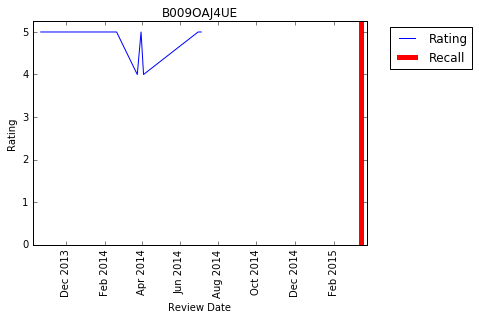

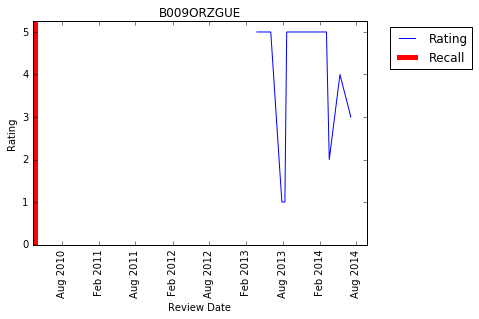

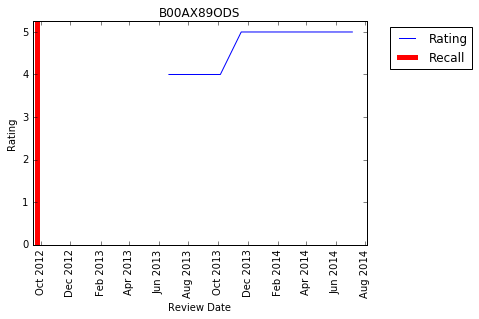

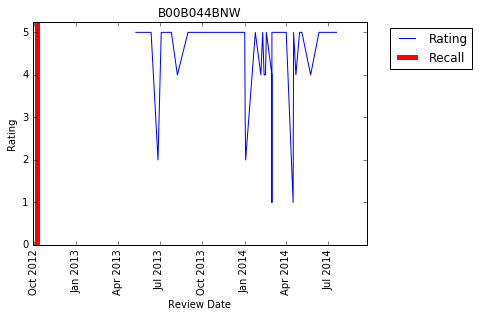

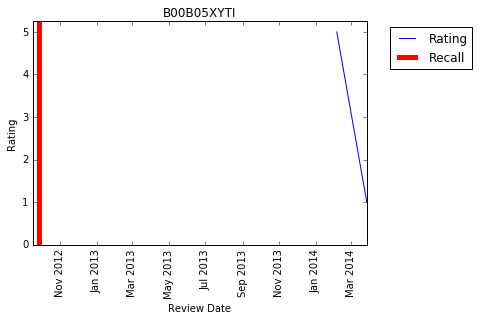

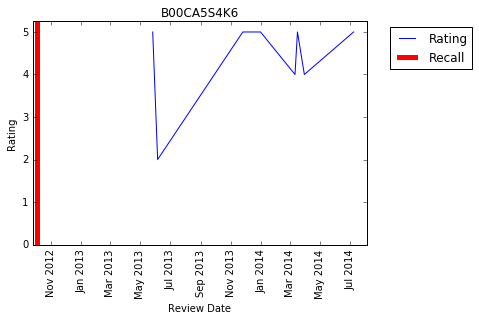

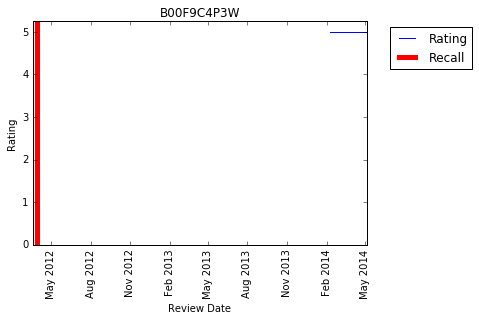

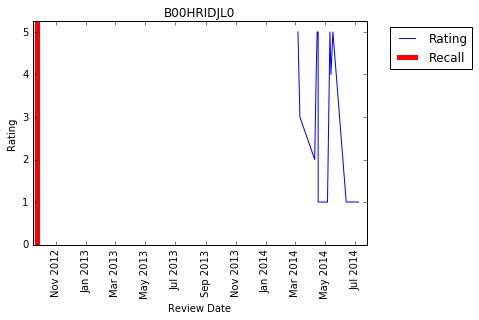

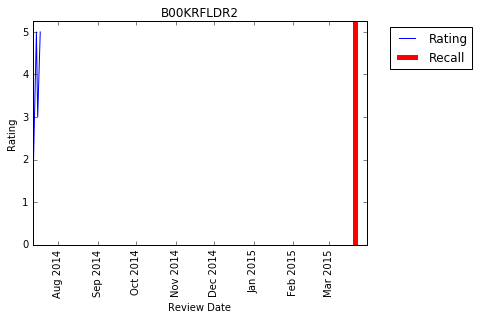

In [231]:
##Evaluate Graphs
unique_asins = combined_df['asin'].unique() 

for asin in unique_asins:
    plotRatingbyASIN(asin)

In [232]:
combined_df[combined_df['asin'] == 'B001DGYKG0']

,overall,helpful,reviewerID,reviewerName,asin,reviewTime,summary,unixReviewTime,reviewText,recalled,Recall_date
1368,4.0,"[0, 0]",A3BC51PZJ8L67R,"Adam Lasnik ""Frim Fram Sauce Extraordinaire""",B001DGYKG0,"05 5, 2012",Absolutely delicious! But a bit high in sugar :(,2012-05-05,I had the pleasure of sampling this product ea...,True,2013-03-28
1369,1.0,"[0, 0]",A2NVZDWHT32N6N,Alice Cheng,B001DGYKG0,"03 1, 2014",These are NOT dairy free.,2014-03-01,I am lactose intolerant and got these because ...,True,2013-03-28
1370,5.0,"[0, 0]",A1UFWUJ8G8YS2G,Amazon Customer,B001DGYKG0,"01 30, 2013",Great nutrition that tastes good.,2013-01-30,The NuGo products are my new favorite thing. T...,True,2013-03-28
1371,5.0,"[0, 0]",A15E30D5IPP8F4,"Amazon Customer ""joey the cop""",B001DGYKG0,"04 16, 2014",A chocoholics dream while on a diet,2014-04-16,Dark Chocolate chocolate chip NuGo is totally ...,True,2013-03-28
1372,4.0,"[5, 5]",A33LCAIVR9GGPD,btsylynn76,B001DGYKG0,"09 10, 2010","Not bad, would eat again",2010-09-10,"For fun, I went to the nutrition store tonight...",True,2013-03-28
1373,5.0,"[0, 0]",A3OAX7WCNZBJ4I,Judy S Farron,B001DGYKG0,"03 23, 2014",Great for kids,2014-03-23,I pack one of these every morning into my gran...,True,2013-03-28
1374,3.0,"[0, 3]",A1TBT43KJZ6JQE,Judy Smith,B001DGYKG0,"02 17, 2013",OK,2013-02-17,"Pricey, but OK. Beware of too much arginine, t...",True,2013-03-28
1375,5.0,"[0, 0]",A1A11928ZPY841,"Julie ""JW""",B001DGYKG0,"03 21, 2013",Great snack!,2013-03-21,Tastes fantastic! I love these bars. It took...,True,2013-03-28
1376,3.0,"[0, 0]",A11RQQ5001LOE,Lady J,B001DGYKG0,"06 2, 2014",Tasted a little stale,2014-06-02,"We subscribe to this item, but this batch tast...",True,2013-03-28
1377,2.0,"[0, 1]",A2TS4EOYWR44RF,MarcyO,B001DGYKG0,"12 7, 2012",Not worth the calories,2012-12-07,"A friend raved about these, so I had to try th...",True,2013-03-28
